# **Distintos Genes y Distintos Tipos de Cáncer**

**Objetivo:** Utilizar SVM (Suppor Vecto Machines) para generar tres modelos con tres tipos de kernel y comparar su funcionalidad con la base de datos *Khan.csv* proveida por el maestro de la materia de Inteligencia Artificial I. Además de esto se desea realizar distintas pruebas de hipotesis con todas las variables de la base de datos con la finalidad de obtener las más significativas para el modelo.
<p>Debido a que esta actividad es solo para entender el funcionamiento y utilidad de SVM y multiple testing, no se hará uso de ningúna tecnica de validación cruzada para la ejecución de los modelos. Ignoraremos la posibilidad de fuga de datos en esta ocasión en particular.</p>

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

1. Importa los datos a tu ambiente de trabajo y revisa que no haya huecos. Calcula la
diferencia de promedios entre las clases 2 y 4 para todos los genes, e imprime los 10
genes con la mayor diferencia de medias. Indica qué crees que esta diferencia podría
implicar en términos de un estudio de inferencia.

In [123]:
url = 'https://raw.githubusercontent.com/AdrianaPS03/A3.1-SVM-MultipleTesting/refs/heads/main/Khan.csv'
df = pd.read_csv(url)
#Hecho con ayuda de ChatGPT
print(df[df.isnull().any(axis=1)])
df = df.dropna()
print(df[df.isnull().any(axis=1)])

Empty DataFrame
Columns: [X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16, X17, X18, X19, X20, X21, X22, X23, X24, X25, X26, X27, X28, X29, X30, X31, X32, X33, X34, X35, X36, X37, X38, X39, X40, X41, X42, X43, X44, X45, X46, X47, X48, X49, X50, X51, X52, X53, X54, X55, X56, X57, X58, X59, X60, X61, X62, X63, X64, X65, X66, X67, X68, X69, X70, X71, X72, X73, X74, X75, X76, X77, X78, X79, X80, X81, X82, X83, X84, X85, X86, X87, X88, X89, X90, X91, X92, X93, X94, X95, X96, X97, X98, X99, X100, ...]
Index: []

[0 rows x 2309 columns]
Empty DataFrame
Columns: [X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16, X17, X18, X19, X20, X21, X22, X23, X24, X25, X26, X27, X28, X29, X30, X31, X32, X33, X34, X35, X36, X37, X38, X39, X40, X41, X42, X43, X44, X45, X46, X47, X48, X49, X50, X51, X52, X53, X54, X55, X56, X57, X58, X59, X60, X61, X62, X63, X64, X65, X66, X67, X68, X69, X70, X71, X72, X73, X74, X75, X76, X77, X78, X79, X80, X81, X82, X83, X84, X85, 

In [124]:
(df[df['y'] == 2].mean() - df[df['y'] == 4].mean()).abs().sort_values(ascending=False).head(10)

X187     3.323151
X509     2.906537
X2046    2.424515
X2050    2.401783
X129     2.165185
X1645    2.065460
X1319    2.045941
X1955    2.037340
X1003    2.011337
y        2.000000
dtype: float64

Observando estos resultados, si esto se tratara de un estudio de inferencia, significaria que la media entre ambas poblaciones parece de máximo 3.323 unidades, siendo el gen más variable cuando se considera solo la clase *2* y la clase *4* el gen *X187*, las demás variables muestran una media entre 1 y 2, que, tomando en cuenta que el máximo es 3, podría significar una gran variabilidad en los genes que tienen un valor de 2 en adelante entre la clase *2* y la clase *4*. Esto nos dice que hay genes que sí nos ayudan a hacer distinciones entre ambas clases.

2. Calcula el estadístico t y el p-value para comparar las medias de todos los genes entre la
clase 2 y la clase 4 de la base de datos. Usa la metodología de Bonferroni, de Holm, y de
Benjamini-Hochberg para corregir por múltiples pruebas e indica, para cada una, qué
genes tienen una expresión significativamente distinta entre las clases (maneja un control
de 0.05). Te recomiendo usar la función multipletests de statsmodels.stats.multitest

In [127]:
#Código hecho con ayuda de ChatGPT
# Separa las clases 2 y 4
df_filtrado = df[df['y'].isin([2, 4])]
X = df_filtrado.drop(columns=['y'])
y = df_filtrado['y']

# Separar datos por clase
X2 = X[y == 2]
X4 = X[y == 4]

# Inicializa listas para guardar resultados
t_stats = []
p_values = []

# Calcula t-test para cada gen
for gen in X.columns:
    t_stat, p_val = ttest_ind(X2[gen], X4[gen], equal_var=False)  # Welch's t-test
    t_stats.append(t_stat)
    p_values.append(p_val)

# Corrige por múltiples pruebas
bonferroni = multipletests(p_values, alpha=0.05, method='bonferroni')
holm = multipletests(p_values, alpha=0.05, method='holm')
bh = multipletests(p_values, alpha=0.05, method='fdr_bh')  # Benjamini-Hochberg

# Crear un DataFrame con resultados
resultados = pd.DataFrame({
    'Gen': X.columns,
    'T-stat': t_stats,
    'P-value': p_values,
    'Bonferroni_reject': bonferroni[0],
    'Bonferroni_p_adj': bonferroni[1],
    'Holm_reject': holm[0],
    'Holm_p_adj': holm[1],
    'BH_reject': bh[0],
    'BH_p_adj': bh[1]
})

# Mostrar los genes significativos por cada método
significativos_bonferroni = resultados[resultados['Bonferroni_reject']]
significativos_holm = resultados[resultados['Holm_reject']]
significativos_bh = resultados[resultados['BH_reject']]

print(f"Genes significativos con Bonferroni: {len(significativos_bonferroni)}")
print(f"Genes significativos con Holm: {len(significativos_holm)}")
print(f"Genes significativos con Benjamini-Hochberg: {len(significativos_bh)}")

# Mostrar los 10 genes más significativos por valor p
resultados.sort_values(by='P-value').head(10)

Genes significativos con Bonferroni: 72
Genes significativos con Holm: 72
Genes significativos con Benjamini-Hochberg: 296


,Gen,T-stat,P-value,Bonferroni_reject,Bonferroni_p_adj,Holm_reject,Holm_p_adj,BH_reject,BH_p_adj
1002,X1003,-12.879590,4.998692e-17,True,1.153698e-13,True,1.153698e-13,True,1.153698e-13
186,X187,-12.229464,3.716887e-16,True,8.578576e-13,True,8.574859e-13,True,4.289288e-13
2049,X2050,-10.983249,4.084836e-15,True,9.427801e-12,True,9.419631e-12,True,3.062213e-12
1954,X1955,-12.579058,5.307128e-15,True,1.224885e-11,True,1.223293e-11,True,3.062213e-12
1644,X1645,10.827754,8.262889e-15,True,1.907075e-11,True,1.903770e-11,True,3.814150e-12
245,X246,10.558828,1.537507e-14,True,3.548567e-11,True,3.540879e-11,True,5.833619e-12
2045,X2046,-10.842463,1.769295e-14,True,4.083533e-11,True,4.072917e-11,True,5.833619e-12
508,X509,-11.334229,7.555354e-14,True,1.743776e-10,True,1.738487e-10,True,2.179720e-11
1953,X1954,10.178272,9.504059e-14,True,2.193537e-10,True,2.185934e-10,True,2.437263e-11
1388,X1389,9.702610,6.387904e-13,True,1.474328e-09,True,1.468579e-09,True,1.474328e-10


Para la tabla anterior tenemos el valor P sin corregir, que siendo un valor muy pequeño nos dice, básicamente, que es muy poco probable que la diferencia observada entre la clase *2* y la clase *4* sea al azar, pero, ya que realizamos muchas pruebas, muchos de estos valores de P pueden estar dandonos un falso positivo. Para esto es para lo que realizamos las correcciones del valor p con distintas metodologias.
<p>Estas nuevas pruebas reducen las probabilidades de falsos positivos. El más confiable de los tres (o en otras palabras el más estricto), es la metodología Bonferroni. Si la columna <i>Bonferroni_reject</i> tiene como valor <i>True</i>, es bastante seguro que su expresión difiere realmente entre clases 2 y 4.</p>
<p>Las otras dos metodologías ayudan a respaldar esta información, aunque su forma de seleccionar genes significativos sea diferente.</p>

3. Realiza un experimento similar, pero ahora comparando las medias de las 4 clases de la
base de datos. Para lograrlo, en vez de trabajar con el estadístico t, te recomiendo realizar
pruebas de análisis de varianza (ANOVA). Dicha prueba la puedes realizar con la función
f_oneway de scipy.stats, pero revisa bien cómo se deben ingresar los datos a dicha
función, necesitarás primero estratificarlos por clase.

In [130]:
#Código hecho con ayuda de ChatGPT
# Separar las variables de entrada (genes) y la variable de salida (clase)
X = df.drop(columns=['y'])
y = df['y']

# Inicializa listas para resultados
f_stats = []
p_values = []

# Realiza ANOVA para cada gen
for gen in X.columns:
    grupos = [X[y == clase][gen] for clase in sorted(y.unique())]
    f_stat, p_val = f_oneway(*grupos)
    f_stats.append(f_stat)
    p_values.append(p_val)

# Correcciones por múltiples comparaciones
bonferroni = multipletests(p_values, alpha=0.05, method='bonferroni')
holm = multipletests(p_values, alpha=0.05, method='holm')
bh = multipletests(p_values, alpha=0.05, method='fdr_bh')  # Benjamini-Hochberg

# Guardar resultados en un DataFrame
resultados_anova = pd.DataFrame({
    'Gen': X.columns,
    'F-stat': f_stats,
    'P-value': p_values,
    'Bonferroni_reject': bonferroni[0],
    'Bonferroni_p_adj': bonferroni[1],
    'Holm_reject': holm[0],
    'Holm_p_adj': holm[1],
    'BH_reject': bh[0],
    'BH_p_adj': bh[1]
})

# Mostrar resumen
print(f"Genes significativos con Bonferroni: {resultados_anova['Bonferroni_reject'].sum()}")
print(f"Genes significativos con Holm: {resultados_anova['Holm_reject'].sum()}")
print(f"Genes significativos con Benjamini-Hochberg: {resultados_anova['BH_reject'].sum()}")

# Mostrar los 10 genes más significativos por ANOVA
resultados_anova.sort_values(by='P-value').head(10)

Genes significativos con Bonferroni: 404
Genes significativos con Holm: 412
Genes significativos con Benjamini-Hochberg: 1162


,Gen,F-stat,P-value,Bonferroni_reject,Bonferroni_p_adj,Holm_reject,Holm_p_adj,BH_reject,BH_p_adj
1954,X1955,84.364086,1.459035e-24,True,3.367454e-21,True,3.367454e-21,True,2.045755e-21
1388,X1389,83.817537,1.772751e-24,True,4.091510e-21,True,4.089737e-21,True,2.045755e-21
1002,X1003,77.795622,1.618988e-23,True,3.736625e-20,True,3.733387e-20,True,1.245542e-20
2049,X2050,69.230799,4.733702e-22,True,1.092539e-18,True,1.091118e-18,True,2.731346e-19
245,X246,68.414042,6.633722e-22,True,1.531063e-18,True,1.528410e-18,True,3.062126e-19
741,X742,65.572797,2.195548e-21,True,5.067325e-18,True,5.056347e-18,True,8.445542e-19
0,X1,59.118264,3.839240e-20,True,8.860966e-17,True,8.837930e-17,True,1.265852e-17
2161,X2162,56.987623,1.035143e-19,True,2.389109e-16,True,2.381863e-16,True,2.986387e-17
1953,X1954,55.419914,2.182635e-19,True,5.037522e-16,True,5.020061e-16,True,5.597246e-17
1644,X1645,54.768403,2.988392e-19,True,6.897208e-16,True,6.870312e-16,True,6.751740e-17


En esta tabla vemos un par de los genes significativos dentro de los 10 mejores que vimos también en la tabla anterior, aunque ahora estamos analizando más clases que antes. Esto es una buena señal, ya que significa que es muy probable que estos genes contengan información significativa para determinar la clase a la que el cáncer pertenece.
<p>De lo que podemos observar es que ahora en lugar de tener solo 72 variables significativas con el método de Bonferroni, tenemos 404, y este número aumenta con las otras dos metodologías también. Si quisieramos solo utilizar la información que estamos muy seguros de que es importante, seleccionariamos de entre las 404 variables que determinó el método Bonferroni con alguna metodología de valización cruzada para encontrar las que más le convienen al modelo; y si quisieramos ser menos estrictos y utilizar toda la información que se ve interesante, utilizariamos las 1162 variables que determinó el método Benjamini-Hochberg para realizar la misma validación cruzada.</p>

4. Separa los datos en entrenamiento y prueba, construye y entrena un modelo de SVM con
un kernel lineal, con un kernel polinomial de orden 3, y con un kernel radial (puedes usar
los parámetros que gustes, no necesitas optimizar con validación cruzada). Para evitar
que el tiempo de procesamiento sea exagerado, puedes seleccionar solamente algunas
variables, partiendo de los resultados que obtuviste en los puntos anteriores. Esta no es
una práctica adecuada, pues estamos cayendo en una situación de fuga de datos. Lo
ideal sería que la selección de características se basara solamente en experimentos
realizados con los datos de entrenamiento. Pero, en este caso, obviaremos este detalle.

In [143]:
#Código hecho con ayuda de ChatGPT
#Obtener los 10 genes más significativos (menor p-valor ANOVA)
top10_genes = resultados_anova.sort_values(by='P-value').head(10)['Gen'].tolist()

#Filtrar X con solo esos 10 genes
X_top10 = df[top10_genes]
y = df['y']

#Dividir en entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_top10, y, test_size=0.2, stratify=y, random_state=42)

#Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Inicializar los modelos SVM con diferentes kernels
svm_linear = SVC(kernel='linear', random_state=42)
svm_poly = SVC(kernel='poly', degree=3, random_state=42)
svm_rbf = SVC(kernel='rbf', random_state=42)

5. Calcula, para los 3 modelos, las métricas que consideres importantes para comparar los
desempeños. Indica qué opinas sobre los resultados, especificando si crees que uno de
los kernels es mejor para esta tarea específica.


🔍 SVM Lineal
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         5

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



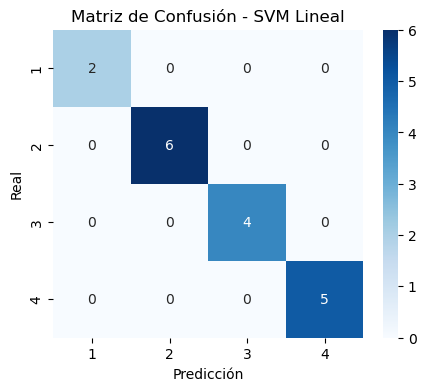


🔍 SVM Polinomial (grado 3)
Accuracy: 0.9412
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       1.00      0.75      0.86         4
           4       0.83      1.00      0.91         5

    accuracy                           0.94        17
   macro avg       0.96      0.94      0.94        17
weighted avg       0.95      0.94      0.94        17



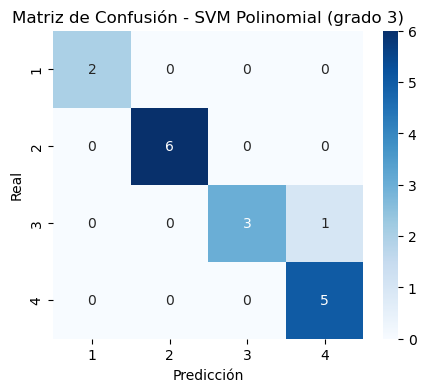


🔍 SVM RBF
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         5

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



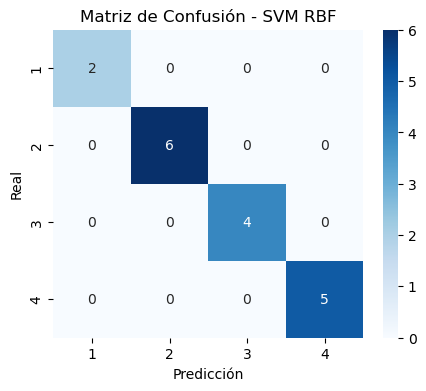

In [149]:
#Código hecho son ayuda de ChatGPT
#Entrenar y evaluar cada modelo
modelos = {
    'SVM Lineal': svm_linear,
    'SVM Polinomial (grado 3)': svm_poly,
    'SVM RBF': svm_rbf
}

for nombre, modelo in modelos.items():
    modelo.fit(X_train_scaled, y_train)
    y_pred = modelo.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    print(f"\n🔍 {nombre}")
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Mostrar matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f'Matriz de Confusión - {nombre}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

Para estos modelos se utilizaron las mismas 10 variables, estas 10 variables fueron las 10 mejores encontradas en el paso 3. Los resultados, ignorando la fuga de datos, son muy buenos. Dos de los tres modelos tienen un accuracy del 100%, y el que no cuenta con este accuracy se acerca mucho, con 94%. Viendo las matrices de confusión, estas nos dicen esta misma información, y también vemos con más claridad lo desbalanceadas que están las clases. Si consideramos que hay una clase con solo 2 datos, es muy probable que, aunque esté haciendo un buen trabajo con esta base de datos, no sea así si agregamos más datos.
<p>Considero que, para la base de datos actual, en las condiciones en las que está, los tres algoritmos hacen un muy buen trabajo. Con las variables elegidas, el kernel lineal y radial son mejores que el polinomial, pues tienen más accuracy, y la elección acerca de cuál usar depende enteramente del usario.</p>

### *Doy mi palabra de que he realizado esta actividad con integridad académica.*